In [23]:
import os
import sys
sys.path.append('../')
sys.path.append('../datasets')
sys.path.append('../models')
import torch
import torchvision
import torch.backends.cudnn as cudnn
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from importlib import reload
from datasets.three_dim_shapes import ThreeDimShapesDataset
from datasets.small_norb import SmallNORBDataset
from datasets.seq_mnist import SequentialMNIST
import models.seqae as seqae
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from datasets import so3_data as so3d
from einops import rearrange
from sklearn.metrics import r2_score
import pdb
from models.base_networks import MLP_iResNet, LinearNet, MLP
from utils import optimize_bd_cob as obc
from importlib import reload



import csv
import ast
from source import yaml_utils as yu


from tqdm import tqdm

if torch.cuda.is_available():
    device = torch.device('cuda')
    cudnn.deterministic = True
    cudnn.benchmark = True
else:
    device = torch.device('cpu')
    gpu_index = -1

    
    
from utils import yaml_utils as yu
import yaml
result_dir = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result'

rootpath = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/'
datpath = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/datasets/so3'





In [2]:
os.listdir(datpath)

['so3dat_sphere_MLP.pt',
 'so3dat_sphere_Linear_model.pt',
 'so3dat_sphere_iResNet_shared_trans.pt',
 'so3dat_sphere_iResNet_model.pt',
 'so3dat_sphere_MLP_shared_trans.pt',
 'so3dat_sphere_Identity_model.pt',
 'so3dat_sphere_Linear_model_invhat.pt',
 'so3dat_sphere_Identity.pt',
 'so3dat_sphere_iResNet.pt',
 'so3dat_sphere_MLP_model.pt',
 'so3dat_sphere_Linear.pt',
 'so3dat_sphere_MLP_model_invhat.pt',
 'so3dat_sphere_Linear_shared_trans.pt']

In [3]:
embed_fxn_mode = 'Linear'
modelmode = 'so3'
num_blocks = 2
tensor_dim = 10 

modelpath = f"""{modelmode}dat_sphere_{embed_fxn_mode}_model.pt"""
datapath = f"""{modelmode}dat_sphere_{embed_fxn_mode}.pt"""

dataconfig = {'args': {'T': 8, 'data_filename': f"""{modelmode}dat_sphere_{embed_fxn_mode}.pt""", 'train': True},
 'fn': './datasets/so3_data.py',
 'name': 'SO3rotationSequence'}

modelconfig = {'args': {'ch_x': 1, 'dim_a': 6, 'dim_m': 10, 'k': 2.0, 'predictive': True},
 'fn': './models/seqae.py',
 'name': f"""SeqAELSTSQ_{modelmode}Net"""}

data = yu.load_component(dataconfig)
datafile = torch.load(os.path.join(datpath, datapath))



if embed_fxn_mode == 'iResNet':
    embed_fxn = MLP_iResNet(in_dim=3*num_blocks*tensor_dim)
    inv_fxn = MLP_iResNet(in_dim=3*num_blocks*tensor_dim)

elif embed_fxn_mode == 'Linear':
    indim= 3 * num_blocks*tensor_dim
    outdim = 3 * num_blocks*tensor_dim
    embed_fxn = LinearNet(in_dim=indim, out_dim=outdim)
    inv_fxn = LinearNet(in_dim=indim, out_dim=outdim)
    mylr = 0.01

elif embed_fxn_mode == 'MLP':
    indim= 3 * num_blocks*tensor_dim
    outdim = 3 * num_blocks*tensor_dim
    embed_fxn = MLP(in_dim=indim, out_dim=outdim)
    inv_fxn = MLP(in_dim=indim, out_dim=outdim)
    mylr = 0.01
    
else:
    raise NotImplementedError

model_dict = torch.load(os.path.join(datpath, modelpath))
embed_fxn.load_state_dict(model_dict, strict=False)








<All keys matched successfully>

In [4]:
latent = datafile['latent']
print(latent.shape)
latent_inform = rearrange(latent, 'n t a m -> (n t) (a m)')
print(latent_inform.shape)

torch.Size([10000, 15, 10, 6])
torch.Size([150000, 60])


torch.Size([150000, 60])


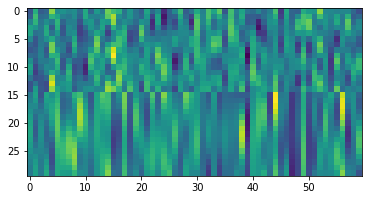

In [5]:
dathat_inform = embed_fxn(latent_inform)
datat = datafile['data']
print(dathat_inform.shape)
plt.imshow(dathat_inform[:30, :].detach())

In [6]:
print(datat.shape)
dat_inform = rearrange(datat, 'n t am -> (n t) am')
print(dat_inform.shape)
dat_inform - embed_fxn(latent_inform)

torch.Size([10000, 15, 60])
torch.Size([150000, 60])


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<SubBackward0>)

In [7]:
datat.shape

torch.Size([10000, 15, 60])

In [8]:
train_loader = DataLoader(latent_inform, 
                          batch_size=100,
                          shuffle=True,
                          num_workers=2)

In [11]:
device = 0
mylr = 0.01
optimizer = torch.optim.Adam(inv_fxn.parameters(), lr=mylr)

num_epoch = 10
num_iter = 1000
iternow = 0 
inv_fxn.to(device)
embed_fxn.to(device)

print(next(inv_fxn.parameters()).device)
print(next(embed_fxn.parameters()).device)

for epoch in range(num_epoch):
    
    loss_total = 0
    for lat_batch in tqdm(train_loader):
        lat_batch = lat_batch.to(device)
        loss = torch.sum( (lat_batch - inv_fxn(embed_fxn(lat_batch)))**2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_total = loss_total + loss.item()
    loss_mean = loss_total / len(train_loader)
    print(f"""Epoch {epoch} \t Loss \t {loss_mean} """ )



cuda:0
cuda:0


100%|██████████| 1500/1500 [00:03<00:00, 400.02it/s]


Epoch 0 	 Loss 	 11.143493593533833 


100%|██████████| 1500/1500 [00:03<00:00, 448.95it/s]


Epoch 1 	 Loss 	 10.007144852956136 


100%|██████████| 1500/1500 [00:03<00:00, 398.72it/s]


Epoch 2 	 Loss 	 8.957936780611673 


100%|██████████| 1500/1500 [00:03<00:00, 411.78it/s]


Epoch 3 	 Loss 	 8.05801975886027 


100%|██████████| 1500/1500 [00:03<00:00, 390.15it/s]


Epoch 4 	 Loss 	 7.192827015558879 


100%|██████████| 1500/1500 [00:03<00:00, 397.47it/s]


Epoch 5 	 Loss 	 6.459103499253591 


100%|██████████| 1500/1500 [00:03<00:00, 396.94it/s]


Epoch 6 	 Loss 	 5.769877443790436 


100%|██████████| 1500/1500 [00:03<00:00, 406.71it/s]


Epoch 7 	 Loss 	 5.12363211552302 


100%|██████████| 1500/1500 [00:03<00:00, 395.10it/s]


Epoch 8 	 Loss 	 4.604979993502299 


100%|██████████| 1500/1500 [00:03<00:00, 391.15it/s]

Epoch 9 	 Loss 	 4.026414385477702 


In [12]:
#torch.sum(torch.abs(latent_inform.reshape([10000, 15, 6, 10])  - latent))
latent_hat = inv_fxn(dat_inform.to(device)).reshape([10000, 15, 10, 6]).detach().to('cpu').numpy()




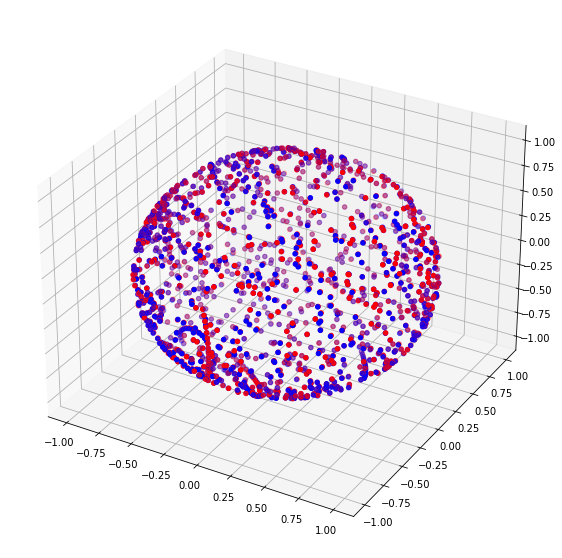

In [13]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
import colorsys



myslice = 0
pos= 1


# rgb = np.asarray(colorsys.hsv_to_rgb(
#     color, 1, 1), dtype=np.float32)
shift= 0
for k in range(100):
    dat = latent[shift+k, :, myslice, pos*3:(pos+1)*3]
    dathat = latent_hat[shift + k,:, myslice, pos*3:(pos+1)*3]
    ax.scatter(dat[:, 0], dat[:, 1], dat[:, 2], color= 'blue')
    ax.scatter(dathat[:, 0], dathat[:, 1], dathat[:, 2], color= 'red')


    #ax.scatter(dat[:,pos*3+0,myslice], dat[:,pos*3+1,myslice], dat[:,pos*3+2,myslice], color='blue')
    #ax.scatter(dathat[:,pos*3+0,myslice], dathat[:,pos*3+1,myslice], dathat[:,pos*3+2,myslice], color='red')
    
    #for t in range(15):



In [14]:
os.listdir(datpath)


['so3dat_sphere_MLP.pt',
 'so3dat_sphere_Linear_model.pt',
 'so3dat_sphere_iResNet_shared_trans.pt',
 'so3dat_sphere_iResNet_model.pt',
 'so3dat_sphere_MLP_shared_trans.pt',
 'so3dat_sphere_Identity_model.pt',
 'so3dat_sphere_Linear_model_invhat.pt',
 'so3dat_sphere_Identity.pt',
 'so3dat_sphere_iResNet.pt',
 'so3dat_sphere_MLP_model.pt',
 'so3dat_sphere_Linear.pt',
 'so3dat_sphere_MLP_model_invhat.pt',
 'so3dat_sphere_Linear_shared_trans.pt']

In [15]:
invname = modelpath.split('.')[0] + '_invhat.pt'
invpath = os.path.join(datpath, invname)
#torch.save(inv_fxn.state_dict(), invpath)
print(invpath)

from models  import seqae as sa
reload(sa)
checkmodel = sa.SeqAELSTSQ_LinearNet(dim_a=6,  dim_m=10)
checkmodel.enc = inv_fxn
checkmodel.dec = embed_fxn

/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/datasets/so3/so3dat_sphere_Linear_model_invhat.pt


/usr/local/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [16]:


n=2
t =15 
latent_b = latent[:n].to('cpu')
print(latent_b.shape)
embed_fxn.to('cpu')
latent_b_input = rearrange(latent_b, 'n t m a -> (n t) (m a)' )
dat_b = embed_fxn(latent_b_input).detach()
print(dat_b.shape)
dat_b = torch.reshape(dat_b,  (n ,t , *dat_b.shape[1:]))
print(dat_b.shape)

torch.Size([2, 15, 10, 6])
torch.Size([30, 60])
torch.Size([2, 15, 60])


In [17]:
dat_bhat = checkmodel.decode(latent_b)
print(dat_bhat.shape)

dat_bhat == dat_b

torch.Size([2, 15, 60])


tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]])

# Matching the M Learning  : this is the sanity check that the model with the true encoder and decoder can retrieve the correct M 

In [18]:
dataconfig

{'args': {'T': 8, 'data_filename': 'so3dat_sphere_Linear.pt', 'train': True},
 'fn': './datasets/so3_data.py',
 'name': 'SO3rotationSequence'}

In [19]:
tp = 3
n_cond = 5


    
Mlist = [] 

dataconfig['args']['T'] = tp + n_cond

data = yu.load_component(dataconfig)
train_loader = DataLoader(data, 
                      batch_size=100,
                      shuffle=True,
                      num_workers=2)

model = checkmodel.eval().to(device)


with torch.no_grad():
    scores = [] 
    for images in tqdm(train_loader):
        images = images.to(device)
        images_cond = images[:, :n_cond]
        images_target = images[:, n_cond:n_cond+tp]
        M = model.get_M(images_cond) #n a a
        H = model.encode(images_cond[:, -1:])[:, 0] # n s a
        
        xs = []
        for r in range(tp):
            H = H @ M 
            x_next_t = model.decode(H[:, None])
            xs.append(x_next_t)

        x_next = torch.cat(xs, axis=1)
        r2_losses = [] 
        for k in range(tp):
            r2_loss_t = r2_score(images_target[:,k].to('cpu').numpy(), x_next[:,k].to('cpu').numpy()) 
            r2_losses.append(r2_loss_t)
        scores.append(torch.tensor(r2_losses))
        Mlist.append(M.to('cpu').detach())


Mlist = torch.cat(Mlist)       
scores = torch.stack(scores)
av_score = torch.mean(scores, axis=0)
av_var = torch.var(scores, axis=0)
results_true_est = [av_score, av_var]


    

100%|██████████| 100/100 [00:01<00:00, 96.52it/s]


In [20]:
results_true_est

[tensor([0.9987, 0.9974, 0.9966], dtype=torch.float64),
 tensor([2.1131e-08, 8.3415e-08, 1.3153e-07], dtype=torch.float64)]

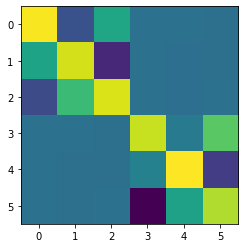

In [21]:
checkidx = 8
plt.imshow(Mlist[checkidx].detach())

ep:4 loss:0.2716601381778717
ep:9 loss:0.26532948408126833
ep:14 loss:0.26091781516075135
ep:19 loss:0.2626718524456024
ep:24 loss:0.2595451735973358
ep:29 loss:0.2573661944389343
ep:34 loss:0.25703902876377105
ep:39 loss:0.2551383250713348
ep:44 loss:0.2553252604961395
ep:49 loss:0.25449917249679566


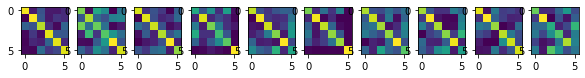

In [30]:
Pmat = obc.optimize_bd_cob(Mlist, epochs_monitor=5, n_epochs=50, lr=0.1)
PSP = Pmat(Mlist).detach().to('cpu')
toshow = 10
plt.figure(figsize= (toshow, 1))
for k in range(toshow):
    plt.subplot(1, toshow, k+1)
    plt.imshow(torch.abs(PSP[k]))



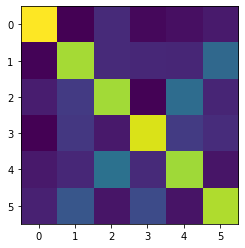

In [28]:
plt.imshow(torch.mean(torch.abs(PSP) , axis =0).detach())

In [29]:
len(Mlist)

10000